In [1]:
#Setup

# Install Packages
import sys
!{sys.executable} -m pip install numpy --quiet
!{sys.executable} -m pip install matplotlib --quiet
!{sys.executable} -m pip install seaborn --quiet
!{sys.executable} -m pip install sklearn --quiet

from sklearn import preprocessing
import os, requests
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.linear_model import LinearRegression
    
# Data Retrieval

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
# Import matplotlib and set styling
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

colourmap_diverge = sns.diverging_palette(321, 172, s=100, n=100, center = "light", as_cmap=True)
colourmap = sns.color_palette("deep", as_cmap=True)
#colourmap = sns.light_palette("#30887c", as_cmap=True)
colourmap_diverge.set_bad("black", alpha=0)
sns.set_palette("deep")
sns.set_style('darkgrid')

# Data Loading
alldat = np.load(fname, allow_pickle=True)['dat']

In [2]:
# Load patient 2
dat = alldat[0, 2]
# Selected channels of high correlations for patient 2
corr_chan = sorted([5, 23, 22, 20, 17, 1, 25])

V = dat['V']
V_corr = dat['V'][:,corr_chan]
if False: #Change to true to use only correlated channels
    V = V_corr
nt, nchan = V_corr.shape
print(nt, nchan)

cx = dat['cursorX'].flatten()
cy = dat['cursorY'].flatten()

134360 7


In [3]:
def normalise(signal):
    signal_norm = (signal - min(signal))/(max(signal) - min(signal))
    return signal_norm

norm = True
if norm:
    cx = normalise(cx)
    cy = normalise(cy)
    for c in range(nchan):
        V[:,c] = normalise(V[:,c].flatten())

In [4]:
# split into 80:20 train test split
nt, nchan = V.shape

boundary = math.ceil(nt*0.8)

V_train = V[:boundary, :]
V_test = V[boundary:, :]

cx_train = cx[:boundary]
cx_test = cx[boundary:]
cy_train = cy[:boundary]
cy_test = cy[boundary:]

In [5]:
#Define linear regression functions
import numpy as np
from sklearn.linear_model import LinearRegression

def construct_matrices (_V, _cx, _cy, _h, _l):
    # Construct test matrices
    nt, nchan = _V.shape

    # Generate feature indices
    i0 = _h*_l
    iN = nt
    test_step = 1
    indices = range(i0, iN, test_step)

    # Generate 
    no_obs = len(indices)
    no_vars_rgand = 2    #Number of regressand variables (x and y)
    no_vars_rgor = len(corr_chan) * (_h+1)

    regressand = np.zeros((no_obs, no_vars_rgand))
    regressor = np.zeros((no_obs, no_vars_rgor))

    for j, ind in enumerate(indices):
        regressand[j, 0] = _cx[ind]
        regressand[j, 1] = _cy[ind]
        for i, chan in enumerate(corr_chan):
            for h in range(_h+1):
                regressor[j, (_h+1)*i + h] = _V[ind - h*_l, i]
    return regressor, regressand

def LR_fit(regor, regand):
    reg = LinearRegression()
    reg.fit(regor, regand)
    #print('shape:', reg.coef_.shape)
    #print('score:', reg.score(regor, regand))
    return reg

def LR_predict(regor, _model):
    predict = _model.predict(regor[:,:])
    return predict

def LR(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l):
    _regressor_train, _regressand_train = construct_matrices(_V_train, _cx_train, _cy_train, _h, _l)
    _regressor_test, _regressand_test = construct_matrices(_V_test, _cx_test, _cy_test, _h, _l)


    _model = LR_fit(_regressor_train, _regressand_train)
    _prediction = LR_predict(_regressor_test, _model)

    return _regressand_test, _prediction

def LR_plot(prediction, truth, h, l):
    loss = rms(prediction, truth)
    ax=plt.figure()
    plt.suptitle('hindsight = ' + str(h) + ', lag = ' + str(l) + '; rms = ' + str(loss))
    plt.subplot(1, 2, 1)
    t = np.arange(len(prediction[:,0]))
    sns.lineplot(t, prediction[:,0], label='cursorX Prediction', linewidth=0.5)
    sns.lineplot(t, truth[:,0], label='cursorX True', color='#C44E52')
    plt.xlabel('Sample n')
    plt.ylabel('Normalised position')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.lineplot(t, prediction[:,1], label='cursorY Prediction', linewidth=0.5)
    sns.lineplot(t, truth[:,1], label='cursorY True', color='#C44E52')
    plt.xlabel('Sample n')
    plt.ylabel('Normalised position')
    plt.legend()

In [6]:
def rms(sig1, sig2):
    _diff = sig1 - sig2
    _diff_flat = _diff.flatten()
    _rms = np.sqrt(np.mean(_diff_flat**2))
    #Normalise by sample length
    return _rms

def pearson(sig1, sig2):
    _corrX = np.corrcoef(sig1[:,0], sig2[:,0])[0,1]
    _corrY = np.corrcoef(sig2[:,1], sig1[:,1])[0,1]
    return _corrX, _corrY

In [7]:
def MA(signal, window):
    hindsight = []
    signal_smoothed = []
    for i in range(len(signal)):
        hindsight.append(signal[i])
        if len(hindsight) > window:
            hindsight.pop(0)
        signal_smoothed.append(np.mean(hindsight))
    return signal_smoothed

def smooth_prediction(signal, window):
    out = np.zeros_like(signal)
    out[:,0] = MA(signal[:,0], window)
    out[:,1] = MA(signal[:,1], window)
    return out
    

C:\Users\richa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\richa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\richa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorato

0.22207928082466663


C:\Users\richa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\richa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\richa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorato

0.22089552581779148


NameError: name 'plot_trajectories' is not defined

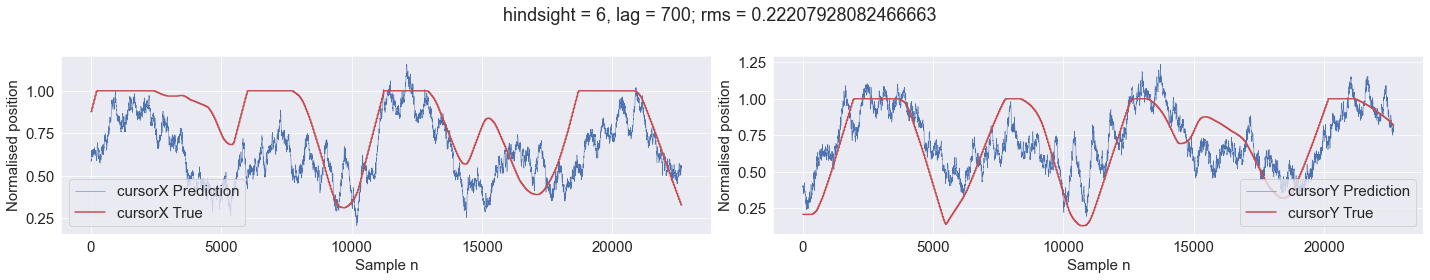

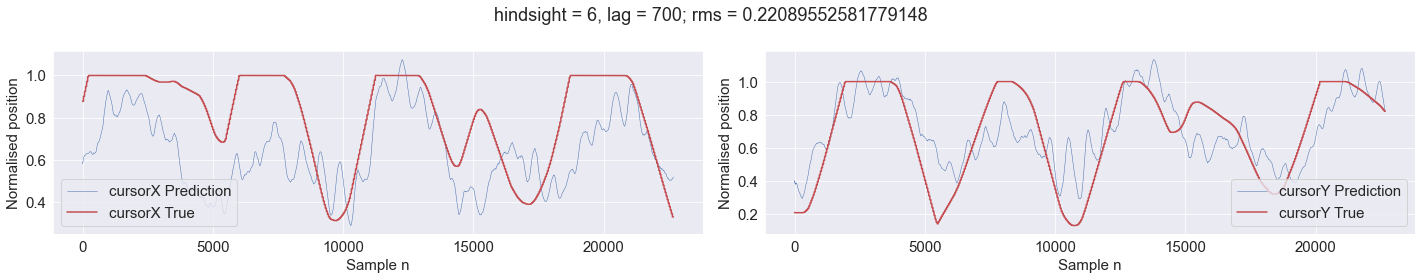

In [60]:
#Generate and visualise response for arbitrary parameters
h=6
l=700
truth, prediction = LR(V_train, cx_train, cy_train, V_test, cx_test, cy_test, h, l)
LR_plot(prediction, truth, h, l)
print(rms(truth, prediction))


prediction_smoothed = smooth_prediction(prediction, 200)
LR_plot(prediction_smoothed, truth, h, l)
print(rms(truth, prediction_smoothed))

plot_trajectories(truth, prediction, shadow=True)
plot_trajectories(truth, prediction_smoothed, shadow=True)


C:\Users\richa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\richa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
50
100
150
200
250
300
350
400
450


Text(0, 0.5, 'RMS Loss')

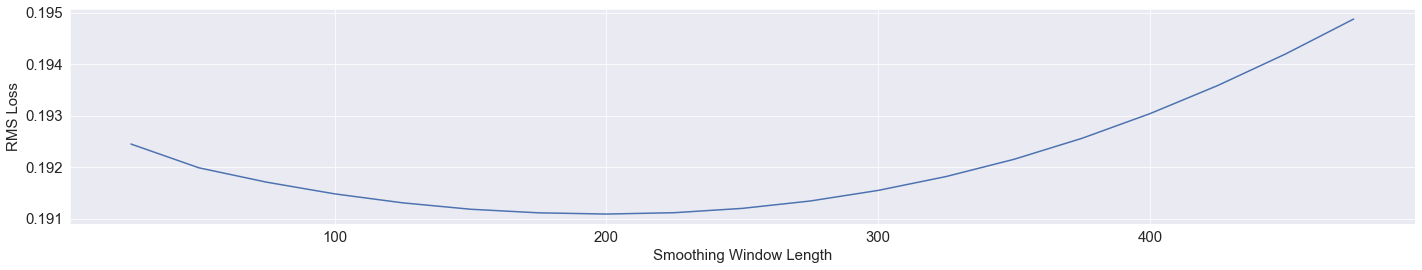

In [10]:
truth_train, prediction_train = LR(V_train, cx_train, cy_train, V_train, cx_train, cy_train, h, l)

losses_smoothing = []
windows = []
for i in np.arange(0, 500, 25):
    prediction_smoothed = smooth_prediction(prediction_train, i)
    loss = rms(truth_train, prediction_smoothed)
    losses_smoothing.append(loss)
    windows.append(i)
    
    if i%50==0:
        print(i)
    
plt.plot(windows, losses_smoothing)
plt.xlabel('Smoothing Window Length')
plt.ylabel('RMS Loss')
    
    
    

float64
(19, 9) <class 'numpy.ndarray'>
9
100
200
300
400
500
600
700
800
900
[[0.23416237 0.21996308 0.20901645 0.19992387 0.19505579 0.19496362
  0.19245153 0.1928498  0.19468021]
 [0.2340671  0.2199909  0.20892781 0.1996265  0.19479569 0.19460291
  0.19198984 0.19232286 0.19424203]
 [0.23404081 0.22010644 0.20893595 0.19945332 0.19465144 0.19441031
  0.19171064 0.1920324  0.19401109]
 [0.23404126 0.22026247 0.20898044 0.19931322 0.19452844 0.19424429
  0.19148432 0.19179671 0.19381895]
 [0.23406843 0.22046018 0.20906833 0.19921031 0.19444481 0.19410099
  0.19131053 0.19161573 0.19367437]
 [0.23412074 0.2207035  0.2092043  0.19916061 0.19440659 0.1939898
  0.1911863  0.19148704 0.19357632]
 [0.23420105 0.22099308 0.20939483 0.19916884 0.19441757 0.1939138
  0.19111677 0.19141505 0.19352701]
 [0.23430793 0.22132597 0.209642   0.19923845 0.19447663 0.19387162
  0.19109298 0.19139524 0.19352552]
 [0.23444197 0.22169658 0.20994992 0.19937684 0.1945914  0.19387937
  0.19111927 0.19143581 

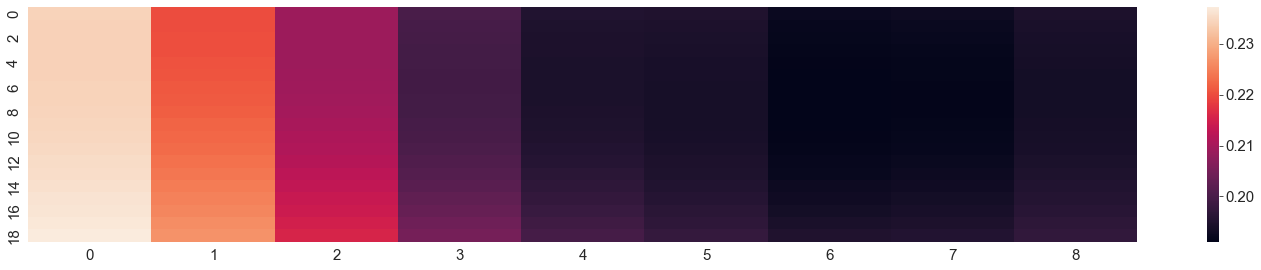

In [46]:
lags = np.arange(100, 1000, 100)
windows = np.arange(25, 500, 25)

lags_mg, windows_mg = np.meshgrid(lags, windows)
losses = np.full_like(lags_mg, 0.0, dtype=np.double)
print(losses.dtype)

print(losses.shape, type(losses))
print(len(lags))

optimal_windows = []
for i, l in enumerate(lags):
    print(l)
    truth_train, prediction_train = LR(V_train, cx_train, cy_train, V_train, cx_train, cy_train, h, l)
    for j, w in enumerate(windows):
        prediction_smoothed = smooth_prediction(prediction_train, w)
        losses[j][i] = rms(truth_train, prediction_smoothed)
        

    
fig = plt.figure()
ax = sns.heatmap(losses)
print(losses)
    

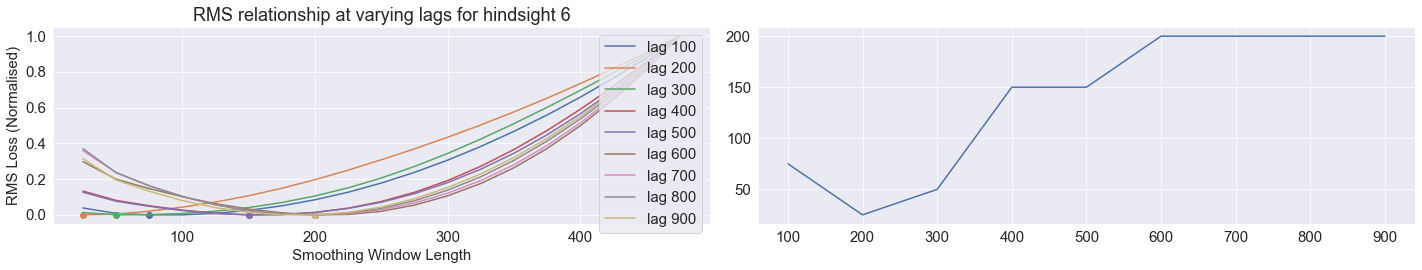

In [66]:
optimal_windows = []
plt.figure()
plt.subplot(1, 2, 1)
plt.xlabel('Smoothing Window Length')
plt.ylabel('RMS Loss (Normalised)')

for i, l in enumerate(lags):
    loss = normalise(losses[:,i])
    p = plt.plot(windows, loss, label="lag "+str(l))
    color = p[-1].get_color()
    min_loss = min(loss)
    optimal_window_index = np.where(loss==min_loss)[0]
    optimal_window = windows[optimal_window_index]
    optimal_windows.append(optimal_window)
    plt.scatter(optimal_window, min_loss, color=color)
plt.legend()

plt.title('RMS relationship at varying lags for hindsight ' + str(h))
plt.subplot(1, 2, 2)
plt.plot(lags, optimal_windows)


In [8]:
## Create linear regression prediction, return RMS value 
def LR_RMS(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l):
    truth, prediction = LR(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l)
    _diff = truth - prediction
    _diff_flat = _diff.flatten()
    _rms = np.sqrt(np.mean(_diff_flat**2))
    #Normalise by sample length
    return _rms

def LR_RMS_norm(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l):
    truth, prediction = LR(_V_train, _cx_train, _cy_train, _V_test, _cx_test, _cy_test, _h, _l)
    _diff = truth - prediction
    _diff_flat = _diff.flatten()
    _rms = np.sqrt(np.mean(_diff_flat**2))
    
    #Normalise by sample length
    _rms_norm = _rms/len(prediction)
    return _rms_norm

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


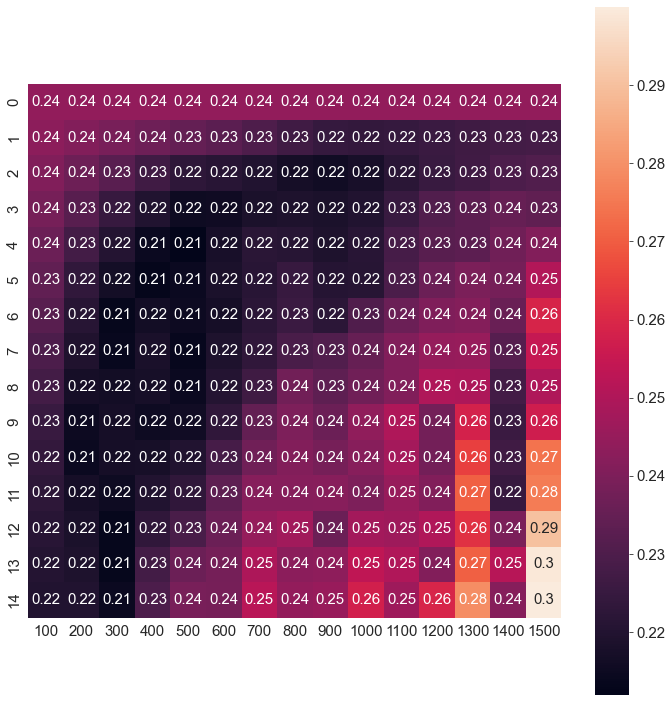

In [31]:
# RMS heatmap, total RMS (not normalised)

hs = range(0, 15)
ls = range(100, 1600, 100)
rmss = np.zeros((len(hs), len(ls)))
for i, h in enumerate(hs):
    print(h)
    for j, l in enumerate(ls):
        truth, prediction = LR(V_train, cx_train, cy_train, V_test, cx_test, cy_test, h, l)
        rmss[i, j] = rms(truth, prediction)
        



Text(0.5, 1.0, 'RMS Grid search for hindsight parameters')

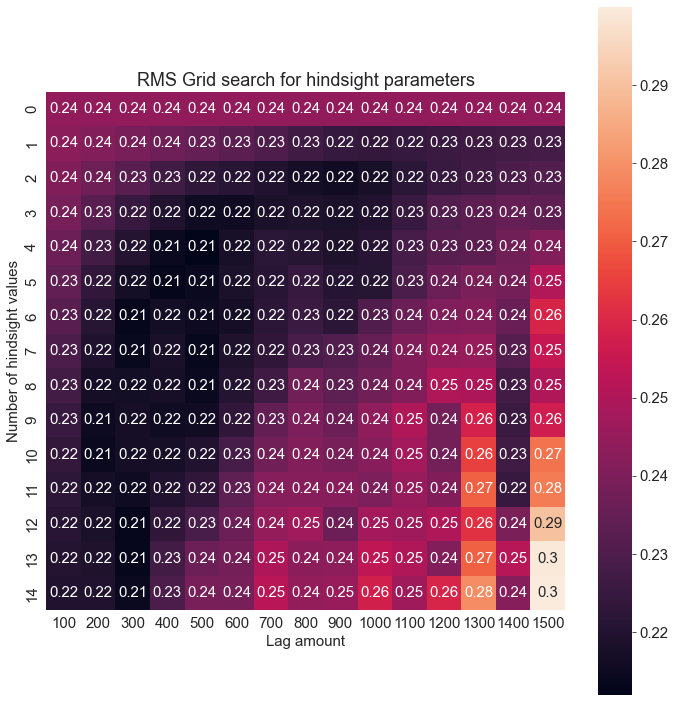

In [32]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
sns.heatmap(rmss, annot=True, xticklabels=ls, yticklabels=hs)
ax.set_aspect('equal', adjustable='box')
plt.xlabel('Lag amount')
plt.ylabel('Number of hindsight values')
plt.title('RMS Grid search for hindsight parameters')


In [ ]:
#Generate and visualise response for lowest error areas
h=5
l=400
truth, prediction = LR(V_train, cx_train, cy_train, V_test, cx_test, cy_test, h, l)
LR_plot(truth, prediction, h, l)

#Generate and visualise response for lowest areas
h=9
l=600
truth, prediction = LR(V_train, cx_train, cy_train, V_test, cx_test, cy_test, h, l)
LR_plot(truth, prediction, h, l)

In [ ]:
# Correlation heatmap

hs = range(2, 20)
ls = range(100, 1000, 100)
corrs = np.zeros((2, len(hs), len(ls)))
for i, h in enumerate(hs):
    for j, l in enumerate(ls):
        truth, prediction = LR(V_train, cx_train, cy_train, V_test, cx_test, cy_test, h, l)
        corrX, corrY = pearson(truth, prediction)
        corrs[0, i, j] = corrX
        corrs[1, i, j] = corrY



In [ ]:
# Visualise above heatmap
plt.figure()
plt.subplot(1,2,1)
sns.heatmap(corrs[0,:,:], annot=True, xticklabels=ls, yticklabels=hs)
plt.subplot(1,2,2)
sns.heatmap(corrs[1,:,:], annot=True, xticklabels=ls, yticklabels=hs)

In [ ]:
#Generate and visualise response for highest correlated areas
h=7
l=300
truth, prediction = LR(V_train, cx_train, cy_train, V_test, cx_test, cy_test, h, l)
LR_plot(truth, prediction, h, l)

#Generate and visualise response for highest correlated areas
h=10
l=400
truth, prediction = LR(V_train, cx_train, cy_train, V_test, cx_test, cy_test, h, l)
LR_plot(truth, prediction, h, l)

In [39]:
def bin_trajectory(x, y, nbins):
  bin_x = np.array_split(x, nbins)
  bin_y = np.array_split(y, nbins)
  bin_traj = []
  
  for i in range(len(bin_x)):
    traj_chunk = np.asarray([bin_x[i], bin_y[i]])
    bin_traj.append(traj_chunk)

  binsize = traj_chunk.shape[1]
  return bin_traj, binsize

def plot_trajectories(true, preds, nbins = 5, shadow = False):
  true_traj_bin, binsize = bin_trajectory(true[:,0], true[:,1], nbins=nbins)
  pred_traj_bin, binsize = bin_trajectory(preds[:,0], preds[:,1], nbins=nbins)

  print(int(binsize/4))

  h = 3
  plt.figure(figsize = (h*nbins, h))
  for i, b in enumerate(range(nbins)):
    plt.subplot(1, nbins, b+1)
    if shadow:
      for j in [-1, 1]:
        try:
          plt.plot(true_traj_bin[i+j][0][int(binsize/4):], true_traj_bin[i+j][1][int(binsize/4):], color='gainsboro')
          plt.plot(pred_traj_bin[i+j][0][:int(binsize/4)], pred_traj_bin[i+j][1][:int(binsize/4)], color='gainsboro')
        except:
          pass
      
    plt.plot(pred_traj_bin[i][0], pred_traj_bin[i][1], label="predicted trajectory")
    plt.plot(true_traj_bin[i][0], true_traj_bin[i][1], label="true trajectory", color='#C44E52')


  plt.legend()


1133


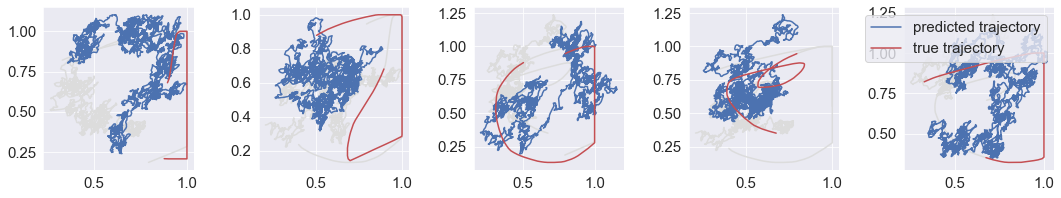

In [16]:
plot_trajectories(truth, prediction, shadow=True)